In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

Total number of categories: 150
Total number of images in dataset: 11090


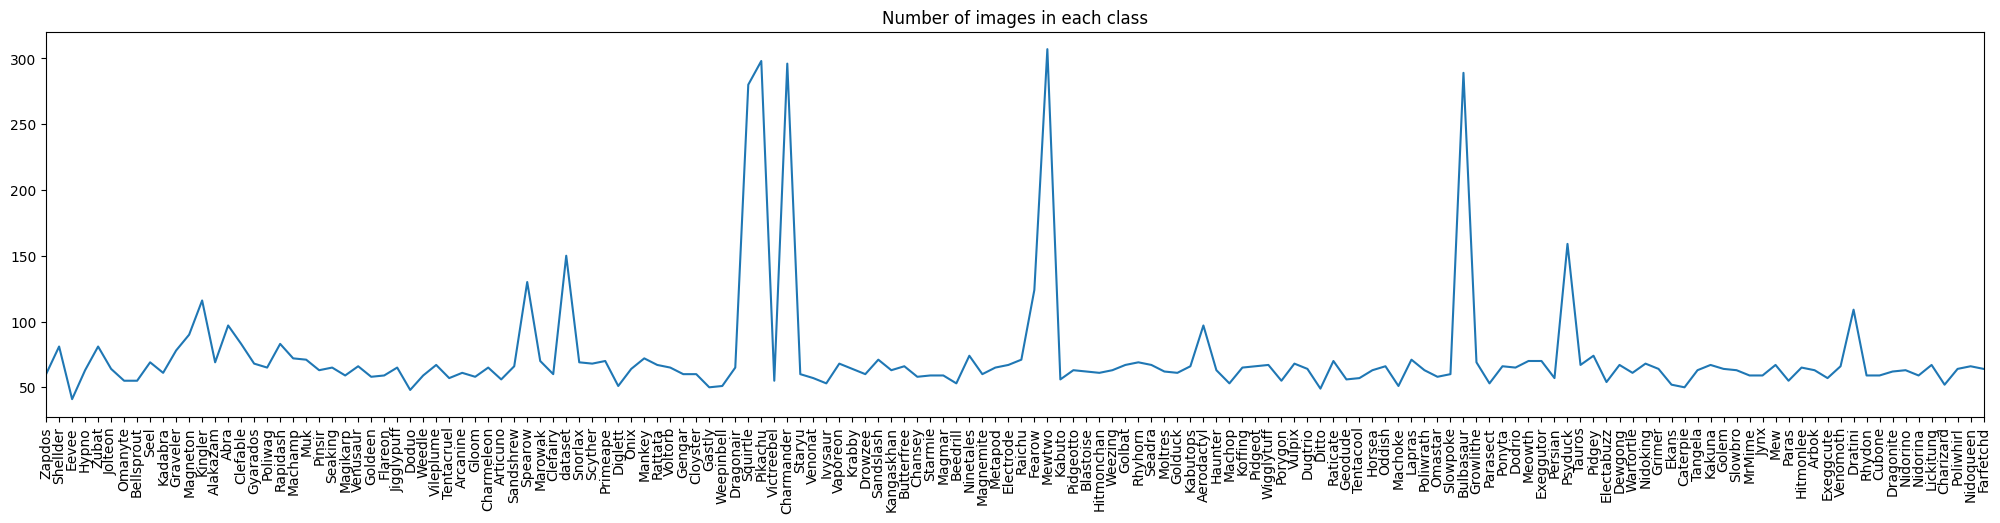

Top 5 Pokemon with the most images:
Mewtwo: 307 images
Pikachu: 298 images
Charmander: 296 images
Bulbasaur: 289 images
Squirtle: 280 images


In [ ]:
path = '/content/drive/MyDrive/Gen1'
classes = os.listdir(path)
print(f'Total number of categories: {len(classes)}')

# Contiene le classi, insieme con il numero di immagini
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))

print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Per visualizzare graficamente il numero di immagini per ogni classe
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Mostrare i 5 pokémon con più immagini
top_5_pokemon = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Pokemon with the most images:")
for pokemon, count in top_5_pokemon:
    print(f"{pokemon}: {count} images")

In [ ]:
# ordine del dizionario (si prendono le 5 classi più numerose)
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

imbalanced = [i[0] for i in imbalanced] # Si prendono le labels delle classi più ampie
print(imbalanced)

[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [ ]:
X = [] # immagini
Y = [] # etichette

for c in classes:
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c)

        # lettura delle immagini
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))

            try:
                resized = cv.resize(image, (96, 96)) # ridimensionamento delle immagini
                X.append(resized)
                Y.append(label)

            # In caso di errori si salta l'immagine
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue

print('DONE')

/content/drive/MyDrive/Gen1/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


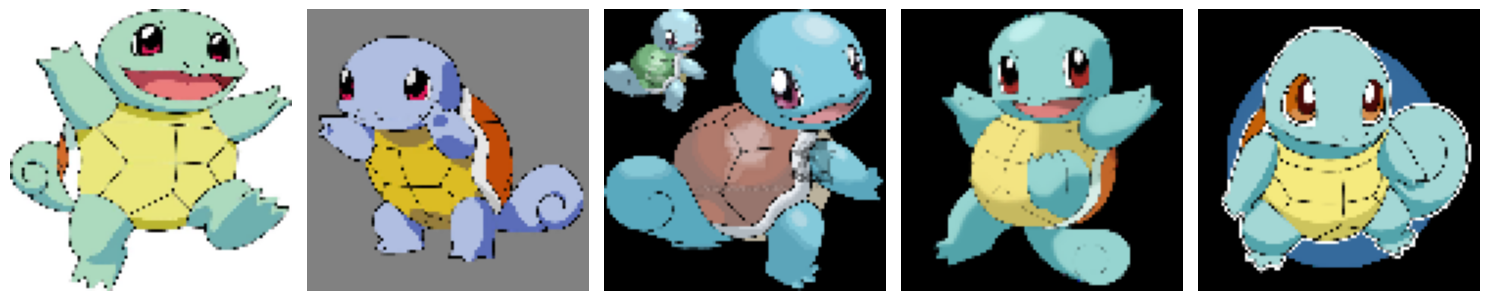

In [ ]:
# numero di immagini da stampare
num_images = 5

# plot per ogni immagine
plt.figure(figsize=(15, 8))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X[i][...,::-1])
    plt.axis('off')

plt.tight_layout()
plt.show()

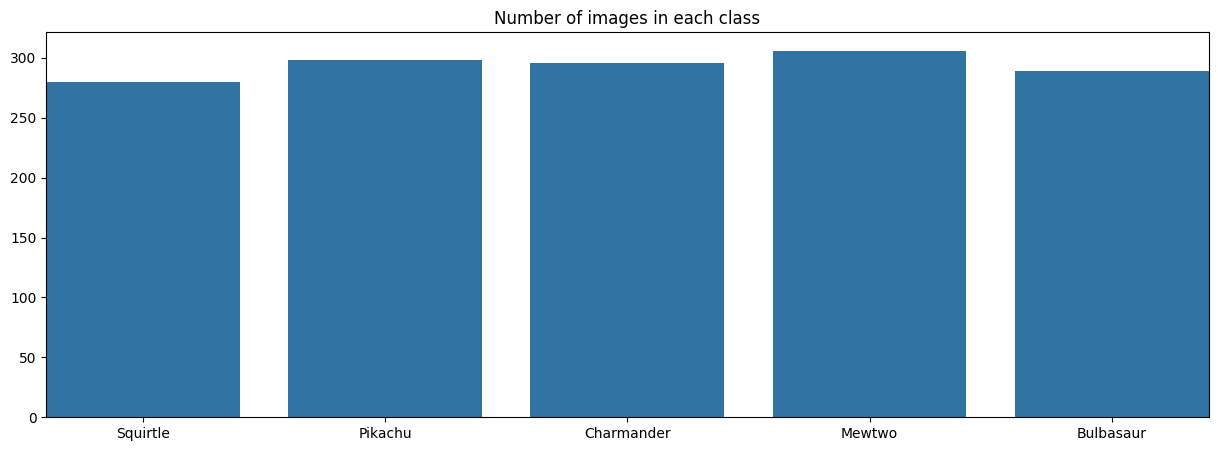

In [ ]:
# Numero di occorrenze per ogni label
obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [ ]:
# la lista diventa un array numpy con le dimensioni desiderate
X = np.array(X).reshape(-1, 96, 96, 3)
X = X / 255.0

# le label vengono convertite
y = to_categorical(Y, num_classes = len(imbalanced))

# splitting in train e test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

In [ ]:
datagen = ImageDataGenerator(rotation_range = 45,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            width_shift_range = 0.15,
                            height_shift_range = 0.15,
                            shear_range = 0.2)

datagen.fit(X_train)

In [ ]:
# PRE-TRAINED CONVNETS
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Carichiamo il modello VGG16 pre-addestrato, escludendo il top layer (ossia lo strato di classificazione)
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# MODELLO N.1

model = Sequential()
model.add(conv_base)  # Aggiungiamo il modello VGG16 pre-addestrato
model.add(Flatten())  # Appiattiamo l'output del modello VGG16
model.add(Dense(256, activation='relu'))  # Aggiungiamo uno strato denso
model.add(Dense(len(imbalanced), activation='softmax'))  # Strato di output finale per la classificazione

conv_base.trainable = False # Congeliamo i pesi

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
37/37 [==============================] - 177s 5s/step - loss: 0.9277 - accuracy: 0.6647 - val_loss: 0.4565 - val_accuracy: 0.8469
Epoch 2/20
37/37 [==============================] - 179s 5s/step - loss: 0.2601 - accuracy: 0.9183 - val_loss: 0.3675 - val_accuracy: 0.8878
Epoch 3/20
37/37 [==============================] - 176s 5s/step - loss: 0.1314 - accuracy: 0.9702 - val_loss: 0.3506 - val_accuracy: 0.8844
Epoch 4/20
37/37 [==============================] - 176s 5s/step - loss: 0.0880 - accuracy: 0.9796 - val_loss: 0.3590 - val_accuracy: 0.8707
Epoch 5/20
37/37 [==============================] - 178s 5s/step - loss: 0.0702 - accuracy: 0.9821 - val_loss: 0.3812 - val_accuracy: 0.8707
Epoch 6/20
37/37 [==============================] - 168s 5s/step - loss: 0.0508 - accuracy: 0.9889 - val_loss: 0.3589 - val_accuracy: 0.8878
Epoch 7/20
37/37 [==============================] - 175s 5s/step - loss: 0.0493 - accuracy: 0.9898 - val_loss: 0.3750 - val_accuracy: 0.8810
Epoch 8/20
37

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10/10 [==============================] - 35s 3s/step - loss: 0.4428 - accuracy: 0.8639
Test accuracy: 0.8639456033706665


10/10 [==============================] - 54s 5s/step


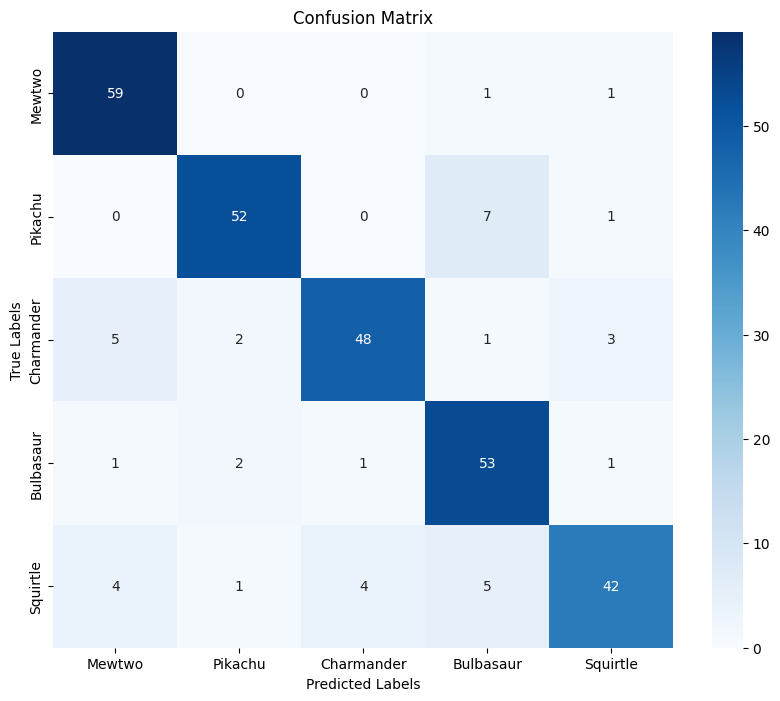

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predizioni del modello sul dataset di test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Visualizzazione della matrice di confusione utilizzando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=imbalanced, yticklabels=imbalanced)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

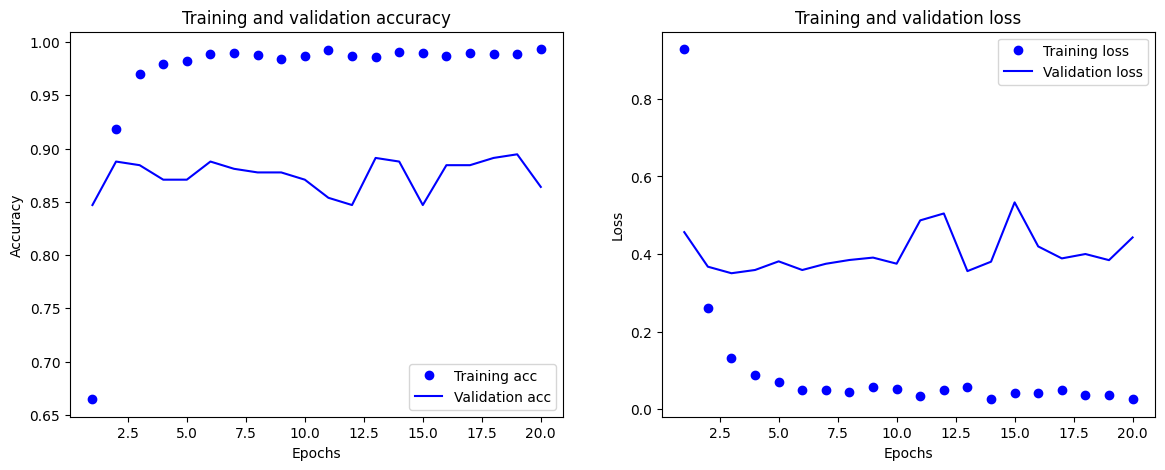

In [ ]:
# Estrazione della storia dell'addestramento dal modello
history_dict = history.history

# valori di accuratezza e loss per training e validation
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Grafico dell'accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Grafico della loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

10/10 [==============================] - 40s 4s/step
              precision    recall  f1-score   support

      Mewtwo       0.86      0.97      0.91        61
     Pikachu       0.91      0.87      0.89        60
  Charmander       0.91      0.81      0.86        59
   Bulbasaur       0.79      0.91      0.85        58
    Squirtle       0.88      0.75      0.81        56

    accuracy                           0.86       294
   macro avg       0.87      0.86      0.86       294
weighted avg       0.87      0.86      0.86       294



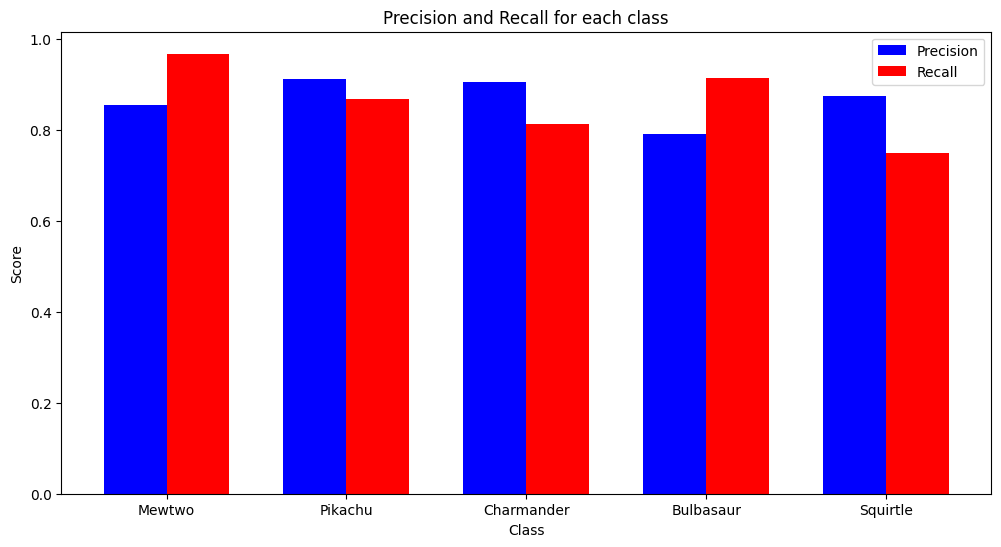

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# predizioni del modello sul dataset di test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# precision, recall, e F1-score per ogni classe
report = classification_report(y_true, y_pred_classes, target_names=imbalanced)
print(report)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes)
x = np.arange(len(imbalanced))

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35

# Grafico della precision
precision_bar = ax.bar(x - bar_width/2, precision, bar_width, label='Precision', color='b')

# Grafico del recall
recall_bar = ax.bar(x + bar_width/2, recall, bar_width, label='Recall', color='r')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision and Recall for each class')
ax.set_xticks(x)
ax.set_xticklabels(imbalanced)
ax.legend()

plt.show()

10/10 [==============================] - 36s 4s/step


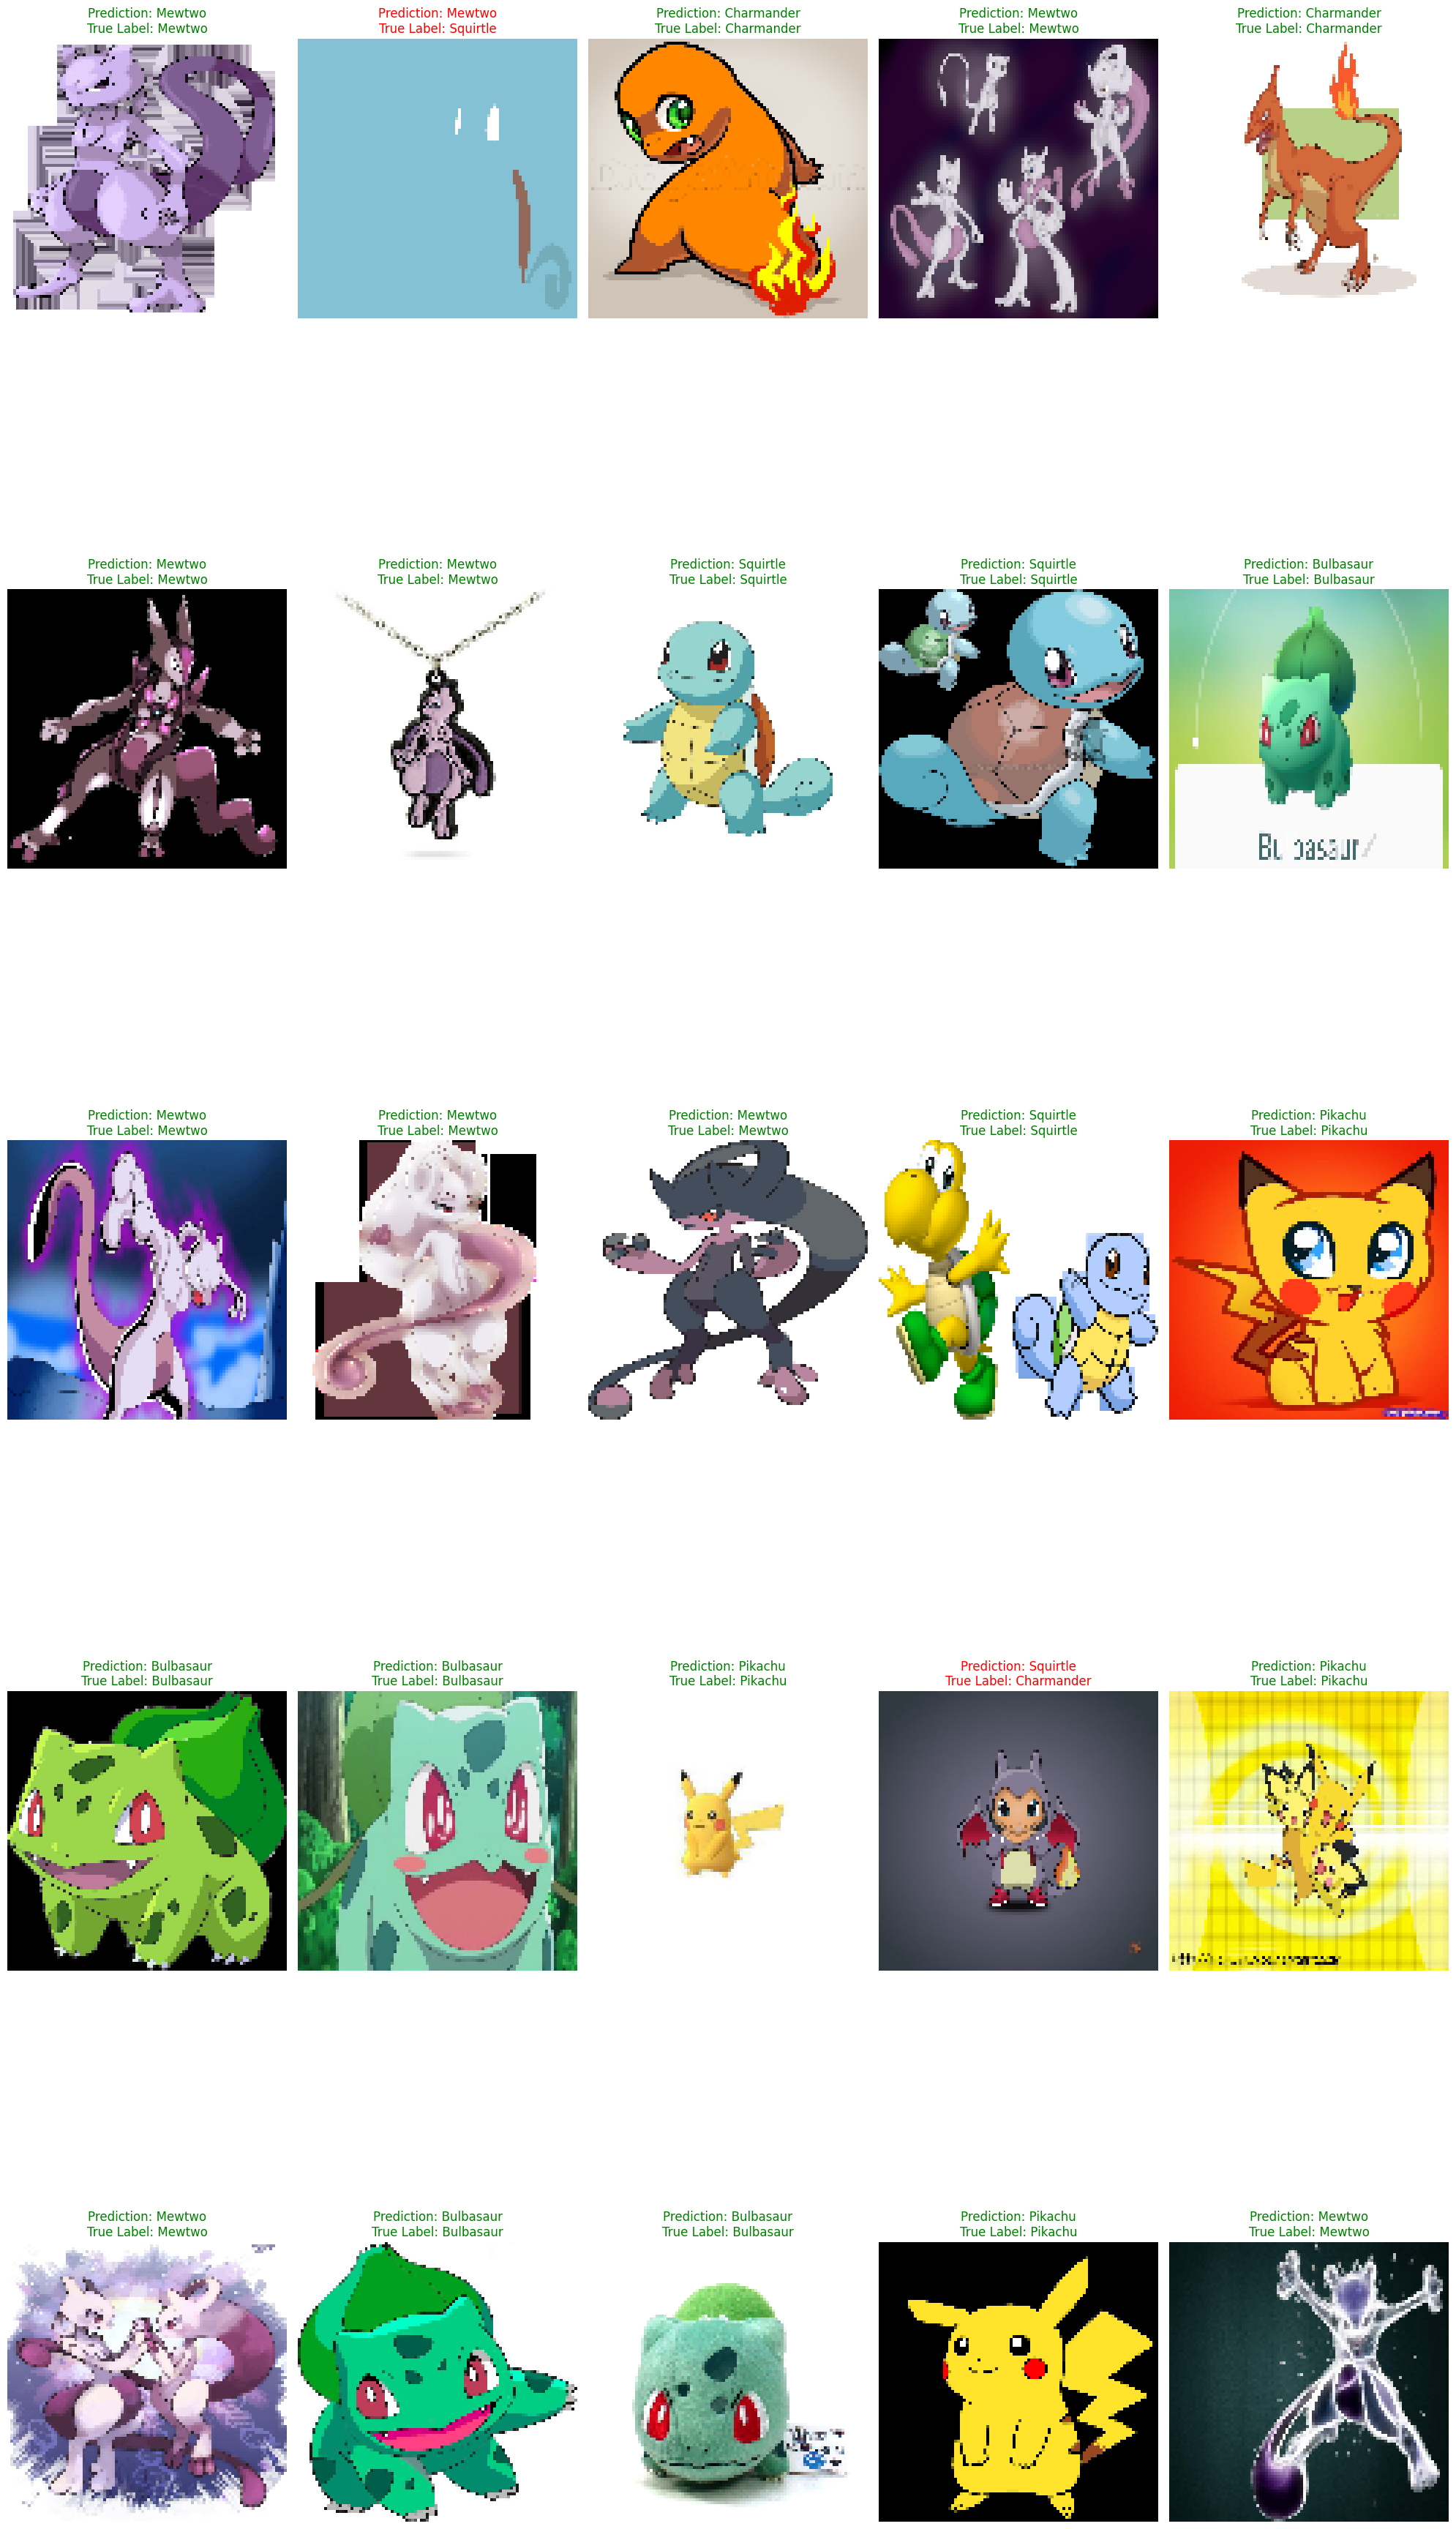

In [ ]:
# Numero di immagini da visualizzare
num_images = 25

num_rows = 5
num_cols = 5

# predizioni del modello sul dataset di test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# campione casuale di immagini e relative predizioni
sample_indices = np.random.choice(range(len(X_test)), size=num_images, replace=False)
sample_images = X_test[sample_indices]
sample_predictions = y_pred_classes[sample_indices]
true_labels = np.argmax(y_test[sample_indices], axis=1)

# visualizzazione
plt.figure(figsize=(20, 40))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i][...,::-1])
    if sample_predictions[i] == true_labels[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Prediction: {imbalanced[sample_predictions[i]]}\nTrue Label: {imbalanced[true_labels[i]]}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

# MODELLO N.2

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model_2 = Sequential()
model_2.add(conv_base)
model_2.add(Flatten())

# dropout per cercare di ridurre overfitting
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

num_classes = 5

model_2.add(Dense(num_classes, activation='softmax'))

conv_base.trainable = False

model_2.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
37/37 [==============================] - 179s 5s/step - loss: 0.9579 - accuracy: 0.6451 - val_loss: 0.5125 - val_accuracy: 0.8299
Epoch 2/20
37/37 [==============================] - 173s 5s/step - loss: 0.4367 - accuracy: 0.8391 - val_loss: 0.4615 - val_accuracy: 0.8299
Epoch 3/20
37/37 [==============================] - 171s 5s/step - loss: 0.2771 - accuracy: 0.9038 - val_loss: 0.4023 - val_accuracy: 0.8537
Epoch 4/20
37/37 [==============================] - 171s 5s/step - loss: 0.2145 - accuracy: 0.9277 - val_loss: 0.4252 - val_accuracy: 0.8367
Epoch 5/20
37/37 [==============================] - 173s 5s/step - loss: 0.1648 - accuracy: 0.9557 - val_loss: 0.3990 - val_accuracy: 0.8537
Epoch 6/20
37/37 [==============================] - 165s 5s/step - loss: 0.1161 - accuracy: 0.9685 - val_loss: 0.4026 - val_accuracy: 0.8741
Epoch 7/20
37/37 [==============================] - 171s 5s/step - loss: 0.0963 - accuracy: 0.9762 - val_loss: 0.3854 - val_accuracy: 0.8571
Epoch 8/20
37

In [ ]:
test_loss, test_acc = model_2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10/10 [==============================] - 35s 3s/step - loss: 0.4565 - accuracy: 0.8639
Test accuracy: 0.8639456033706665


In [ ]:
# Import delle librerie necessarie
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model_3 = Sequential()
model_3.add(conv_base)
model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))  # primo strato densamente connesso
model_3.add(Dropout(0.3))  # dropout 1
model_3.add(Dense(256, activation='relu'))  # secondo strato densamente connesso
model_3.add(Dropout(0.3))  # dropout 2
model_3.add(Dense(128, activation='relu'))  # terzo strato densamente connesso
model_3.add(Dropout(0.3))  # dropout 3
model_3.add(Dense(len(imbalanced), activation='softmax'))

conv_base.trainable = False

model_3.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model_3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 175s 9s/step - loss: 1.5064 - accuracy: 0.3932 - val_loss: 0.8426 - val_accuracy: 0.7551
Epoch 2/50
19/19 [==============================] - 174s 9s/step - loss: 0.7810 - accuracy: 0.6945 - val_loss: 0.4907 - val_accuracy: 0.8367
Epoch 3/50
19/19 [==============================] - 176s 9s/step - loss: 0.4764 - accuracy: 0.8179 - val_loss: 0.4126 - val_accuracy: 0.8503
Epoch 4/50
19/19 [==============================] - 176s 9s/step - loss: 0.2997 - accuracy: 0.8970 - val_loss: 0.4646 - val_accuracy: 0.8605
Epoch 5/50
19/19 [==============================] - 173s 9s/step - loss: 0.2314 - accuracy: 0.9251 - val_loss: 0.4535 - val_accuracy: 0.8503
Epoch 6/50
19/19 [==============================] - 167s 9s/step - loss: 0.1777 - accuracy: 0.9370 - val_loss: 0.4310 - val_accuracy: 0.8776
Epoch 7/50
19/19 [==============================] - 169s 9s/step - loss: 0.1558 - accuracy: 0.9464 - val_loss: 0.5419 - val_accuracy: 0.8571
Epoch 8/50
19

In [ ]:
test_loss, test_acc = model_3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10/10 [==============================] - 33s 3s/step - loss: 0.4828 - accuracy: 0.8707
Test accuracy: 0.8707482814788818


10/10 [==============================] - 34s 3s/step


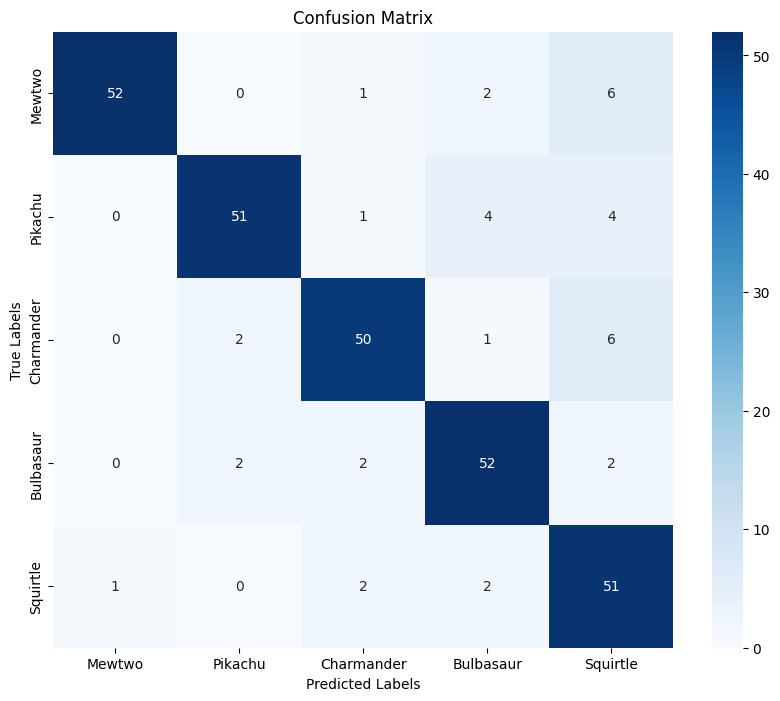

In [ ]:
# MATRICE DI CONFUSIONE MODELLO N.3

from sklearn.metrics import confusion_matrix

y_pred = model_3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=imbalanced, yticklabels=imbalanced)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

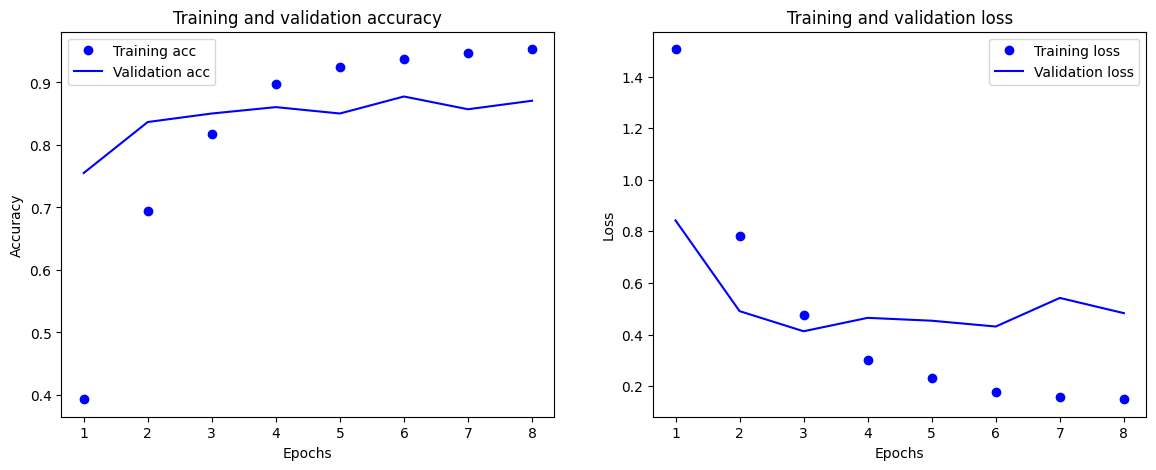

In [ ]:
# ACCURACY FIGURES MODELLO N.3

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

10/10 [==============================] - 33s 3s/step
              precision    recall  f1-score   support

      Mewtwo       0.98      0.85      0.91        61
     Pikachu       0.93      0.85      0.89        60
  Charmander       0.89      0.85      0.87        59
   Bulbasaur       0.85      0.90      0.87        58
    Squirtle       0.74      0.91      0.82        56

    accuracy                           0.87       294
   macro avg       0.88      0.87      0.87       294
weighted avg       0.88      0.87      0.87       294



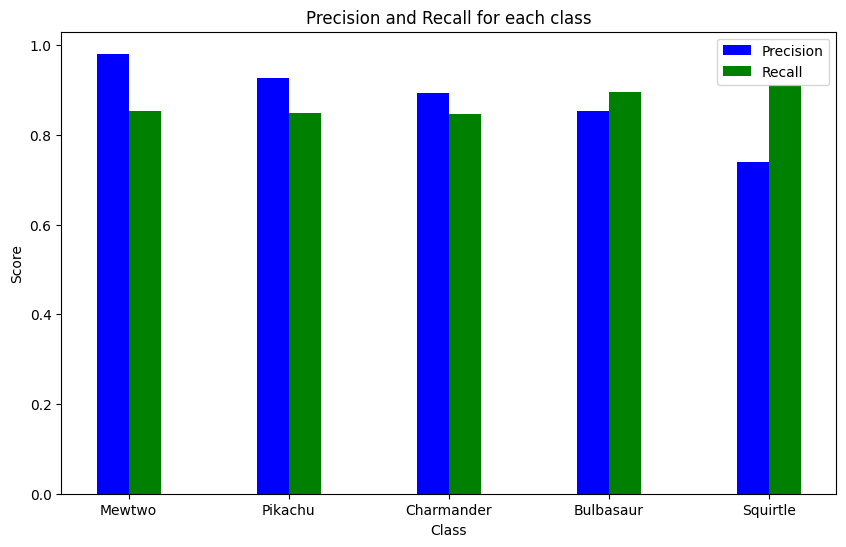

In [ ]:
# RECALL/PRECISION FIGURES MODELLO N.3

from sklearn.metrics import classification_report, precision_recall_fscore_support

y_pred = model_3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=imbalanced)
print(report)

precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred_classes)

x = np.arange(len(imbalanced))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.1, precision, width=0.2, label='Precision', color='b')
plt.bar(x + 0.1, recall, width=0.2, label='Recall', color='g')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall for each class')
plt.xticks(x, imbalanced)
plt.legend()

plt.show()

10/10 [==============================] - 32s 3s/step


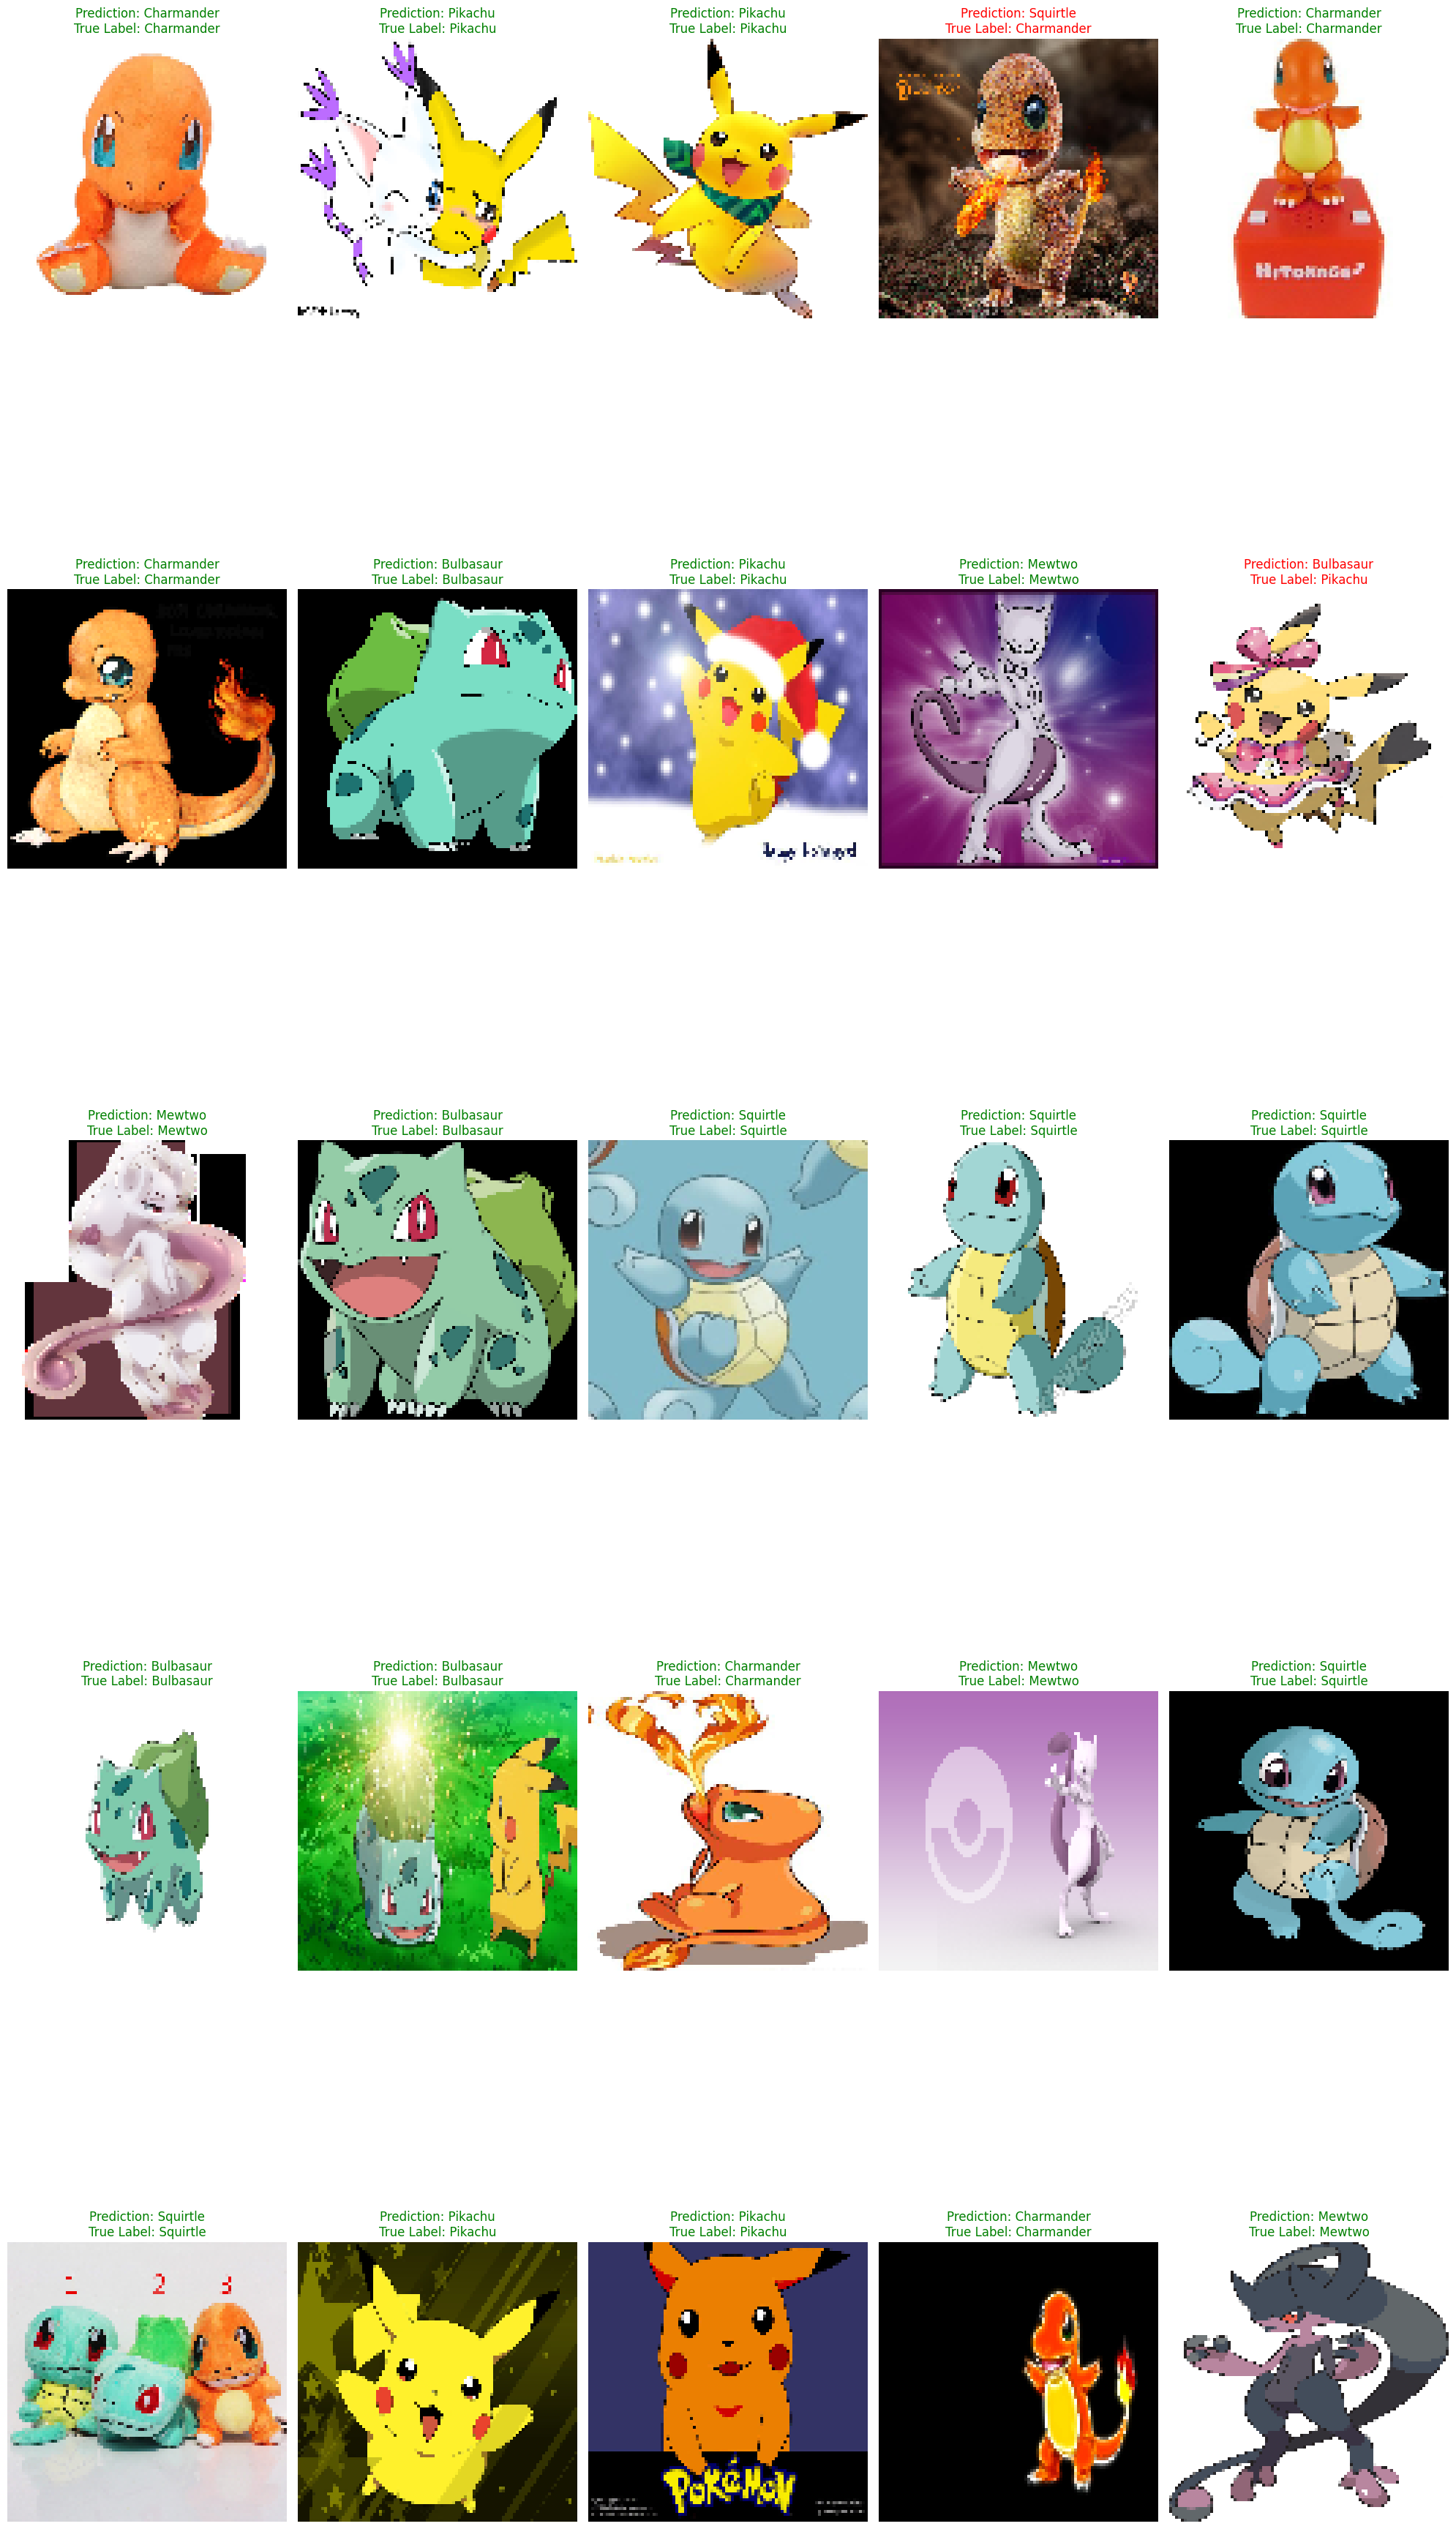

In [ ]:
num_images = 25

num_rows = 5
num_cols = 5

y_pred = model_3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

sample_indices = np.random.choice(range(len(X_test)), size=num_images, replace=False)
sample_images = X_test[sample_indices]
sample_predictions = y_pred_classes[sample_indices]
true_labels = np.argmax(y_test[sample_indices], axis=1)

plt.figure(figsize=(20, 40))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i][...,::-1])
    if sample_predictions[i] == true_labels[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Prediction: {imbalanced[sample_predictions[i]]}\nTrue Label: {imbalanced[true_labels[i]]}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model_4 = Sequential()
model_4.add(conv_base)
model_4.add(Flatten())

strato denso con 1024 unità e attivazione ReLU
model_4.add(Dense(1024, activation='relu'))

# layer di dropout per ridurre l'overfitting
model_4.add(Dropout(0.5))

# strato denso con 512 unità e attivazione ReLU
model_4.add(Dense(512, activation='relu'))

# strato di output per la classificazione
model_4.add(Dense(len(imbalanced), activation='softmax'))

conv_base.trainable = False
model_4.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_4.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Valuta il modello sui dati di test
test_loss, test_accuracy = model_4.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
37/37 [==============================] - 176s 5s/step - loss: 1.1786 - accuracy: 0.5889 - val_loss: 0.4453 - val_accuracy: 0.8401
Epoch 2/50
37/37 [==============================] - 174s 5s/step - loss: 0.4305 - accuracy: 0.8485 - val_loss: 0.4331 - val_accuracy: 0.8469
Epoch 3/50
37/37 [==============================] - 175s 5s/step - loss: 0.2777 - accuracy: 0.9021 - val_loss: 0.5520 - val_accuracy: 0.8197
Epoch 4/50
37/37 [==============================] - 176s 5s/step - loss: 0.2828 - accuracy: 0.8936 - val_loss: 0.5265 - val_accuracy: 0.8435
Epoch 5/50
37/37 [==============================] - 174s 5s/step - loss: 0.2503 - accuracy: 0.9132 - val_loss: 0.4127 - val_accuracy: 0.8741
Epoch 6/50
37/37 [==============================] - 176s 5s/step - loss: 0.1755 - accuracy: 0.9379 - val_loss: 0.3881 - val_accuracy: 0.8605
Epoch 7/50
37/37 [==============================] - 176s 5s/step - loss: 0.1174 - accuracy: 0.9583 - val_loss: 0.4548 - val_accuracy: 0.8639
Epoch 8/50
37

10/10 [==============================] - 33s 3s/step


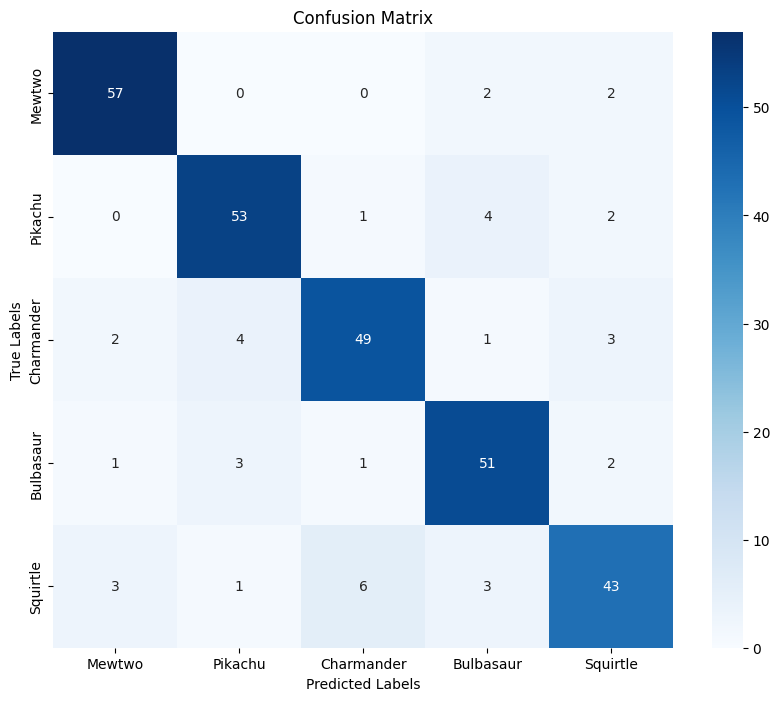

In [ ]:
# MATRICE DI CONFUSIONE MODELLO N.4

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=imbalanced, yticklabels=imbalanced)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

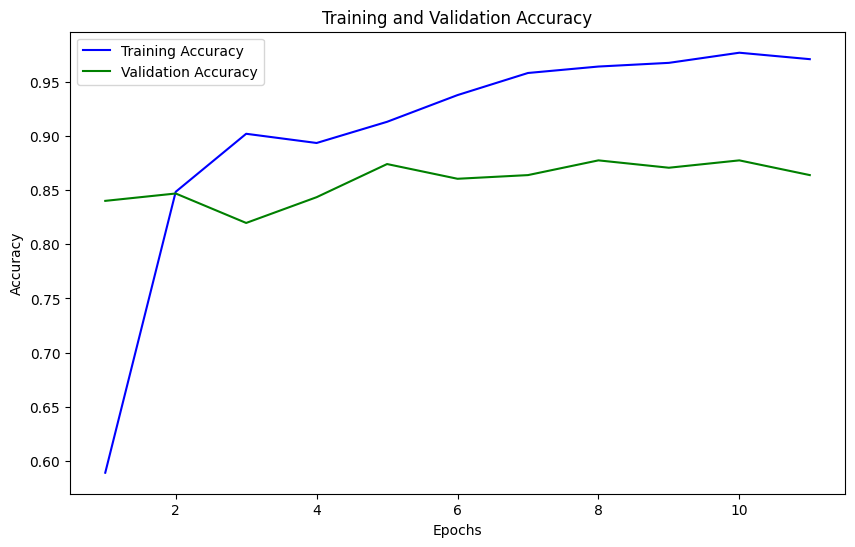

In [ ]:
# ACCURACY FIGURES MODELLO N.4

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

10/10 [==============================] - 33s 3s/step
              precision    recall  f1-score   support

      Mewtwo       0.98      0.85      0.91        61
     Pikachu       0.93      0.85      0.89        60
  Charmander       0.89      0.85      0.87        59
   Bulbasaur       0.85      0.90      0.87        58
    Squirtle       0.74      0.91      0.82        56

    accuracy                           0.87       294
   macro avg       0.88      0.87      0.87       294
weighted avg       0.88      0.87      0.87       294



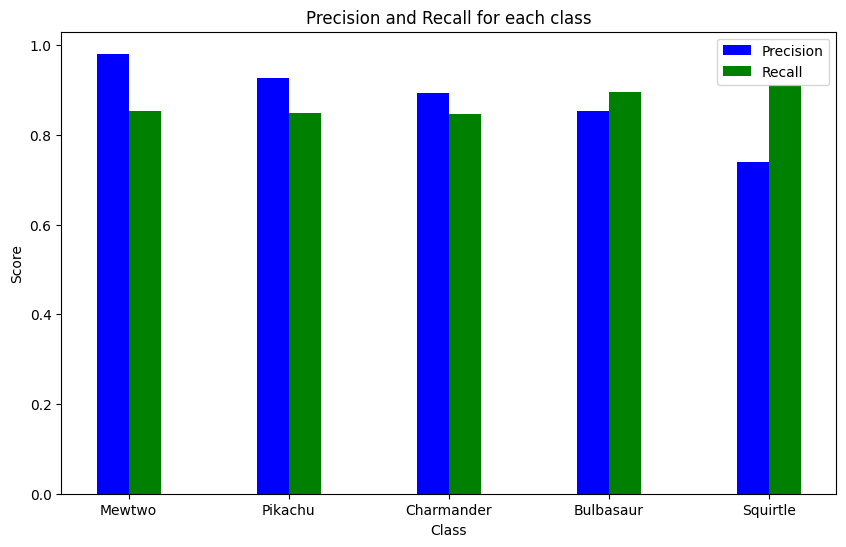

In [ ]:
# RECALL/PRECISION FIGURES MODELLO N.3

from sklearn.metrics import classification_report, precision_recall_fscore_support

y_pred = model_3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=imbalanced)
print(report)

precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred_classes)

x = np.arange(len(imbalanced))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.1, precision, width=0.2, label='Precision', color='b')
plt.bar(x + 0.1, recall, width=0.2, label='Recall', color='g')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall for each class')
plt.xticks(x, imbalanced)
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(imbalanced), activation='softmax'))

base_model.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.hdf5', verbose=1, monitor='val_accuracy', save_best_only=True)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_test, y_test),
                              steps_per_epoch=len(X_train) // 32, callbacks=[checkpoint, early_stopping])

test_loss, test_accuracy = model_4.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 1.7634 - accuracy: 0.4409
Epoch 1: val_accuracy improved from -inf to 0.51020, saving model to best_model.hdf5
36/36 [==============================] - 158s 4s/step - loss: 1.7634 - accuracy: 0.4409 - val_loss: 1.1864 - val_accuracy: 0.5102
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.6360
Epoch 2: val_accuracy improved from 0.51020 to 0.76871, saving model to best_model.hdf5
36/36 [==============================] - 156s 4s/step - loss: 1.0440 - accuracy: 0.6360 - val_loss: 0.6274 - val_accuracy: 0.7687
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.7008
Epoch 3: val_accuracy improved from 0.76871 to 0.78571, saving model to best_model.hdf5
36/36 [==============================] - 141s 4s/step - loss: 0.8391 - accuracy: 0.7008 - val_loss: 0.5337 - val_accuracy: 0.7857
Epoch 4/100
36/36 [==============================] - ETA: 0s - l

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Con più tempo sarebbe interessante valutarne le prestazioni

num_classes = 5

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               1179904   
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15928133 (60.76 MB)
Trainable params: 15

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model_5 = Sequential()
model_5.add(conv_base)
model_5.add(Flatten())
model_5.add(Dense(512, activation='sigmoid'))
model_5.add(Dropout(0.3))
model_5.add(Dense(256, activation='sigmoid'))
model_5.add(Dropout(0.3))
model_5.add(Dense(128, activation='sigmoid'))
model_5.add(Dropout(0.3))
model_5.add(Dense(len(imbalanced), activation='softmax'))

conv_base.trainable = False
model_5.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model_5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
19/19 [==============================] - 177s 9s/step - loss: 1.6292 - accuracy: 0.2528 - val_loss: 1.3778 - val_accuracy: 0.5306
Epoch 2/10
19/19 [==============================] - 166s 9s/step - loss: 1.2254 - accuracy: 0.5370 - val_loss: 0.9322 - val_accuracy: 0.6939
Epoch 3/10
19/19 [==============================] - 175s 9s/step - loss: 0.7823 - accuracy: 0.7617 - val_loss: 0.5748 - val_accuracy: 0.8231
Epoch 4/10
19/19 [==============================] - 173s 9s/step - loss: 0.4548 - accuracy: 0.8774 - val_loss: 0.4542 - val_accuracy: 0.8435
Epoch 5/10
19/19 [==============================] - 173s 9s/step - loss: 0.2844 - accuracy: 0.9302 - val_loss: 0.3938 - val_accuracy: 0.8741
Epoch 6/10
19/19 [==============================] - 174s 9s/step - loss: 0.2110 - accuracy: 0.9532 - val_loss: 0.3834 - val_accuracy: 0.8673
Epoch 7/10
19/19 [==============================] - 175s 9s/step - loss: 0.1390 - accuracy: 0.9677 - val_loss: 0.3629 - val_accuracy: 0.8844
Epoch 8/10
19

In [ ]:
loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

10/10 [==============================] - 33s 3s/step - loss: 0.3976 - accuracy: 0.8810
Test Loss: 0.3975518047809601, Test Accuracy: 0.8809523582458496


10/10 [==============================] - 33s 3s/step


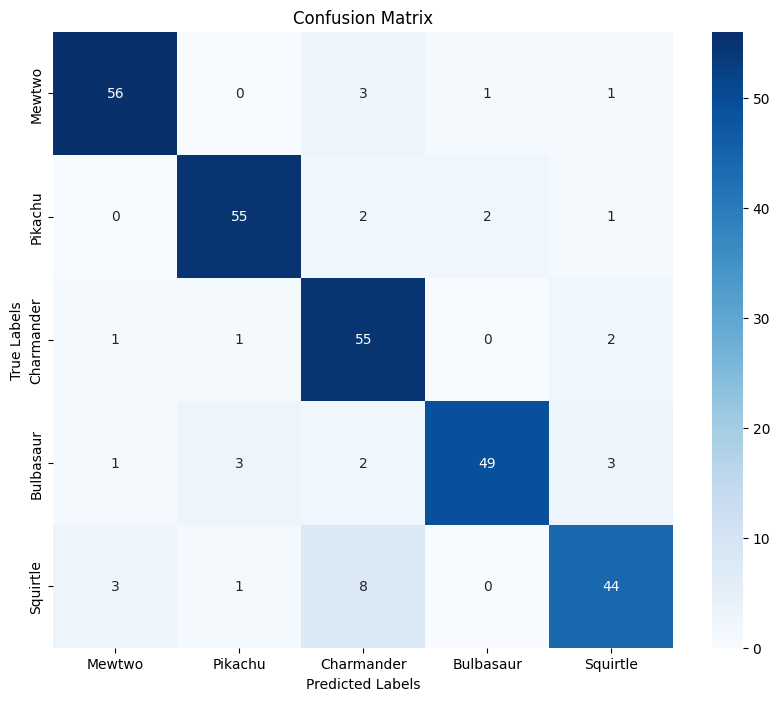

In [ ]:
# MATRICE DI CONFUSIONE MODELLO N.5

from sklearn.metrics import confusion_matrix

y_pred = model_5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=imbalanced, yticklabels=imbalanced)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

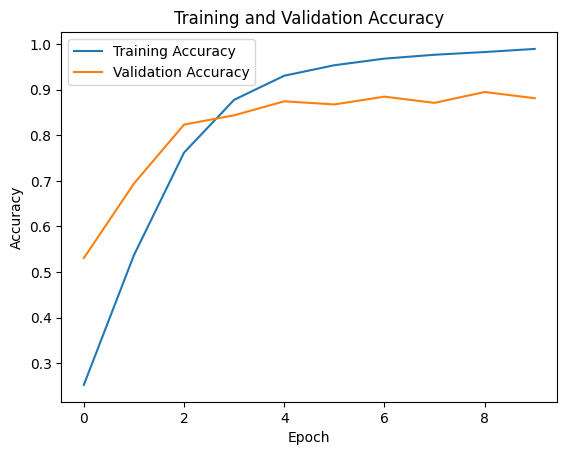

In [ ]:
# ACCURACY FIGURES MODELLO N.5

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

10/10 [==============================] - 34s 3s/step
              precision    recall  f1-score   support

      Mewtwo       0.92      0.92      0.92        61
     Pikachu       0.92      0.92      0.92        60
  Charmander       0.79      0.93      0.85        59
   Bulbasaur       0.94      0.84      0.89        58
    Squirtle       0.86      0.79      0.82        56

    accuracy                           0.88       294
   macro avg       0.89      0.88      0.88       294
weighted avg       0.89      0.88      0.88       294



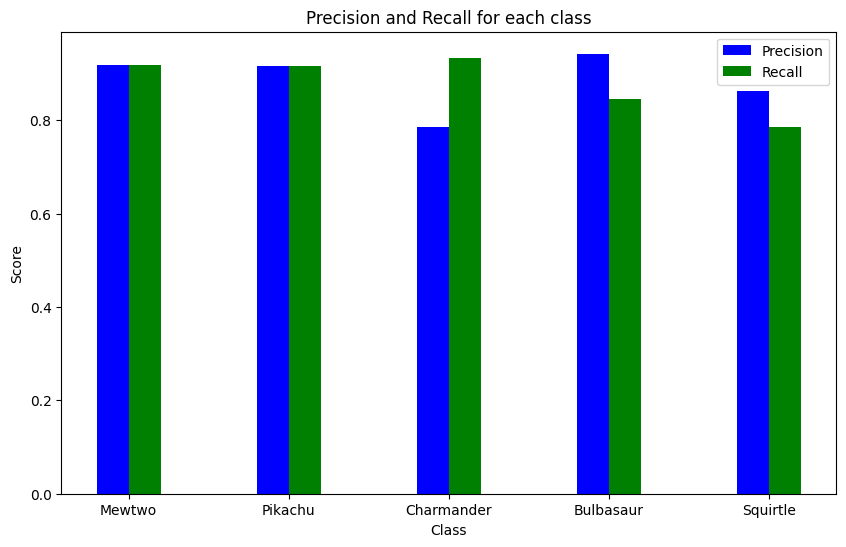

In [ ]:
# RECALL/PRECISION FIGURES MODELLO N.3

from sklearn.metrics import classification_report, precision_recall_fscore_support

y_pred = model_5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=imbalanced)
print(report)

precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred_classes)

x = np.arange(len(imbalanced))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.1, precision, width=0.2, label='Precision', color='b')
plt.bar(x + 0.1, recall, width=0.2, label='Recall', color='g')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall for each class')
plt.xticks(x, imbalanced)
plt.legend()

plt.show()

10/10 [==============================] - 33s 3s/step


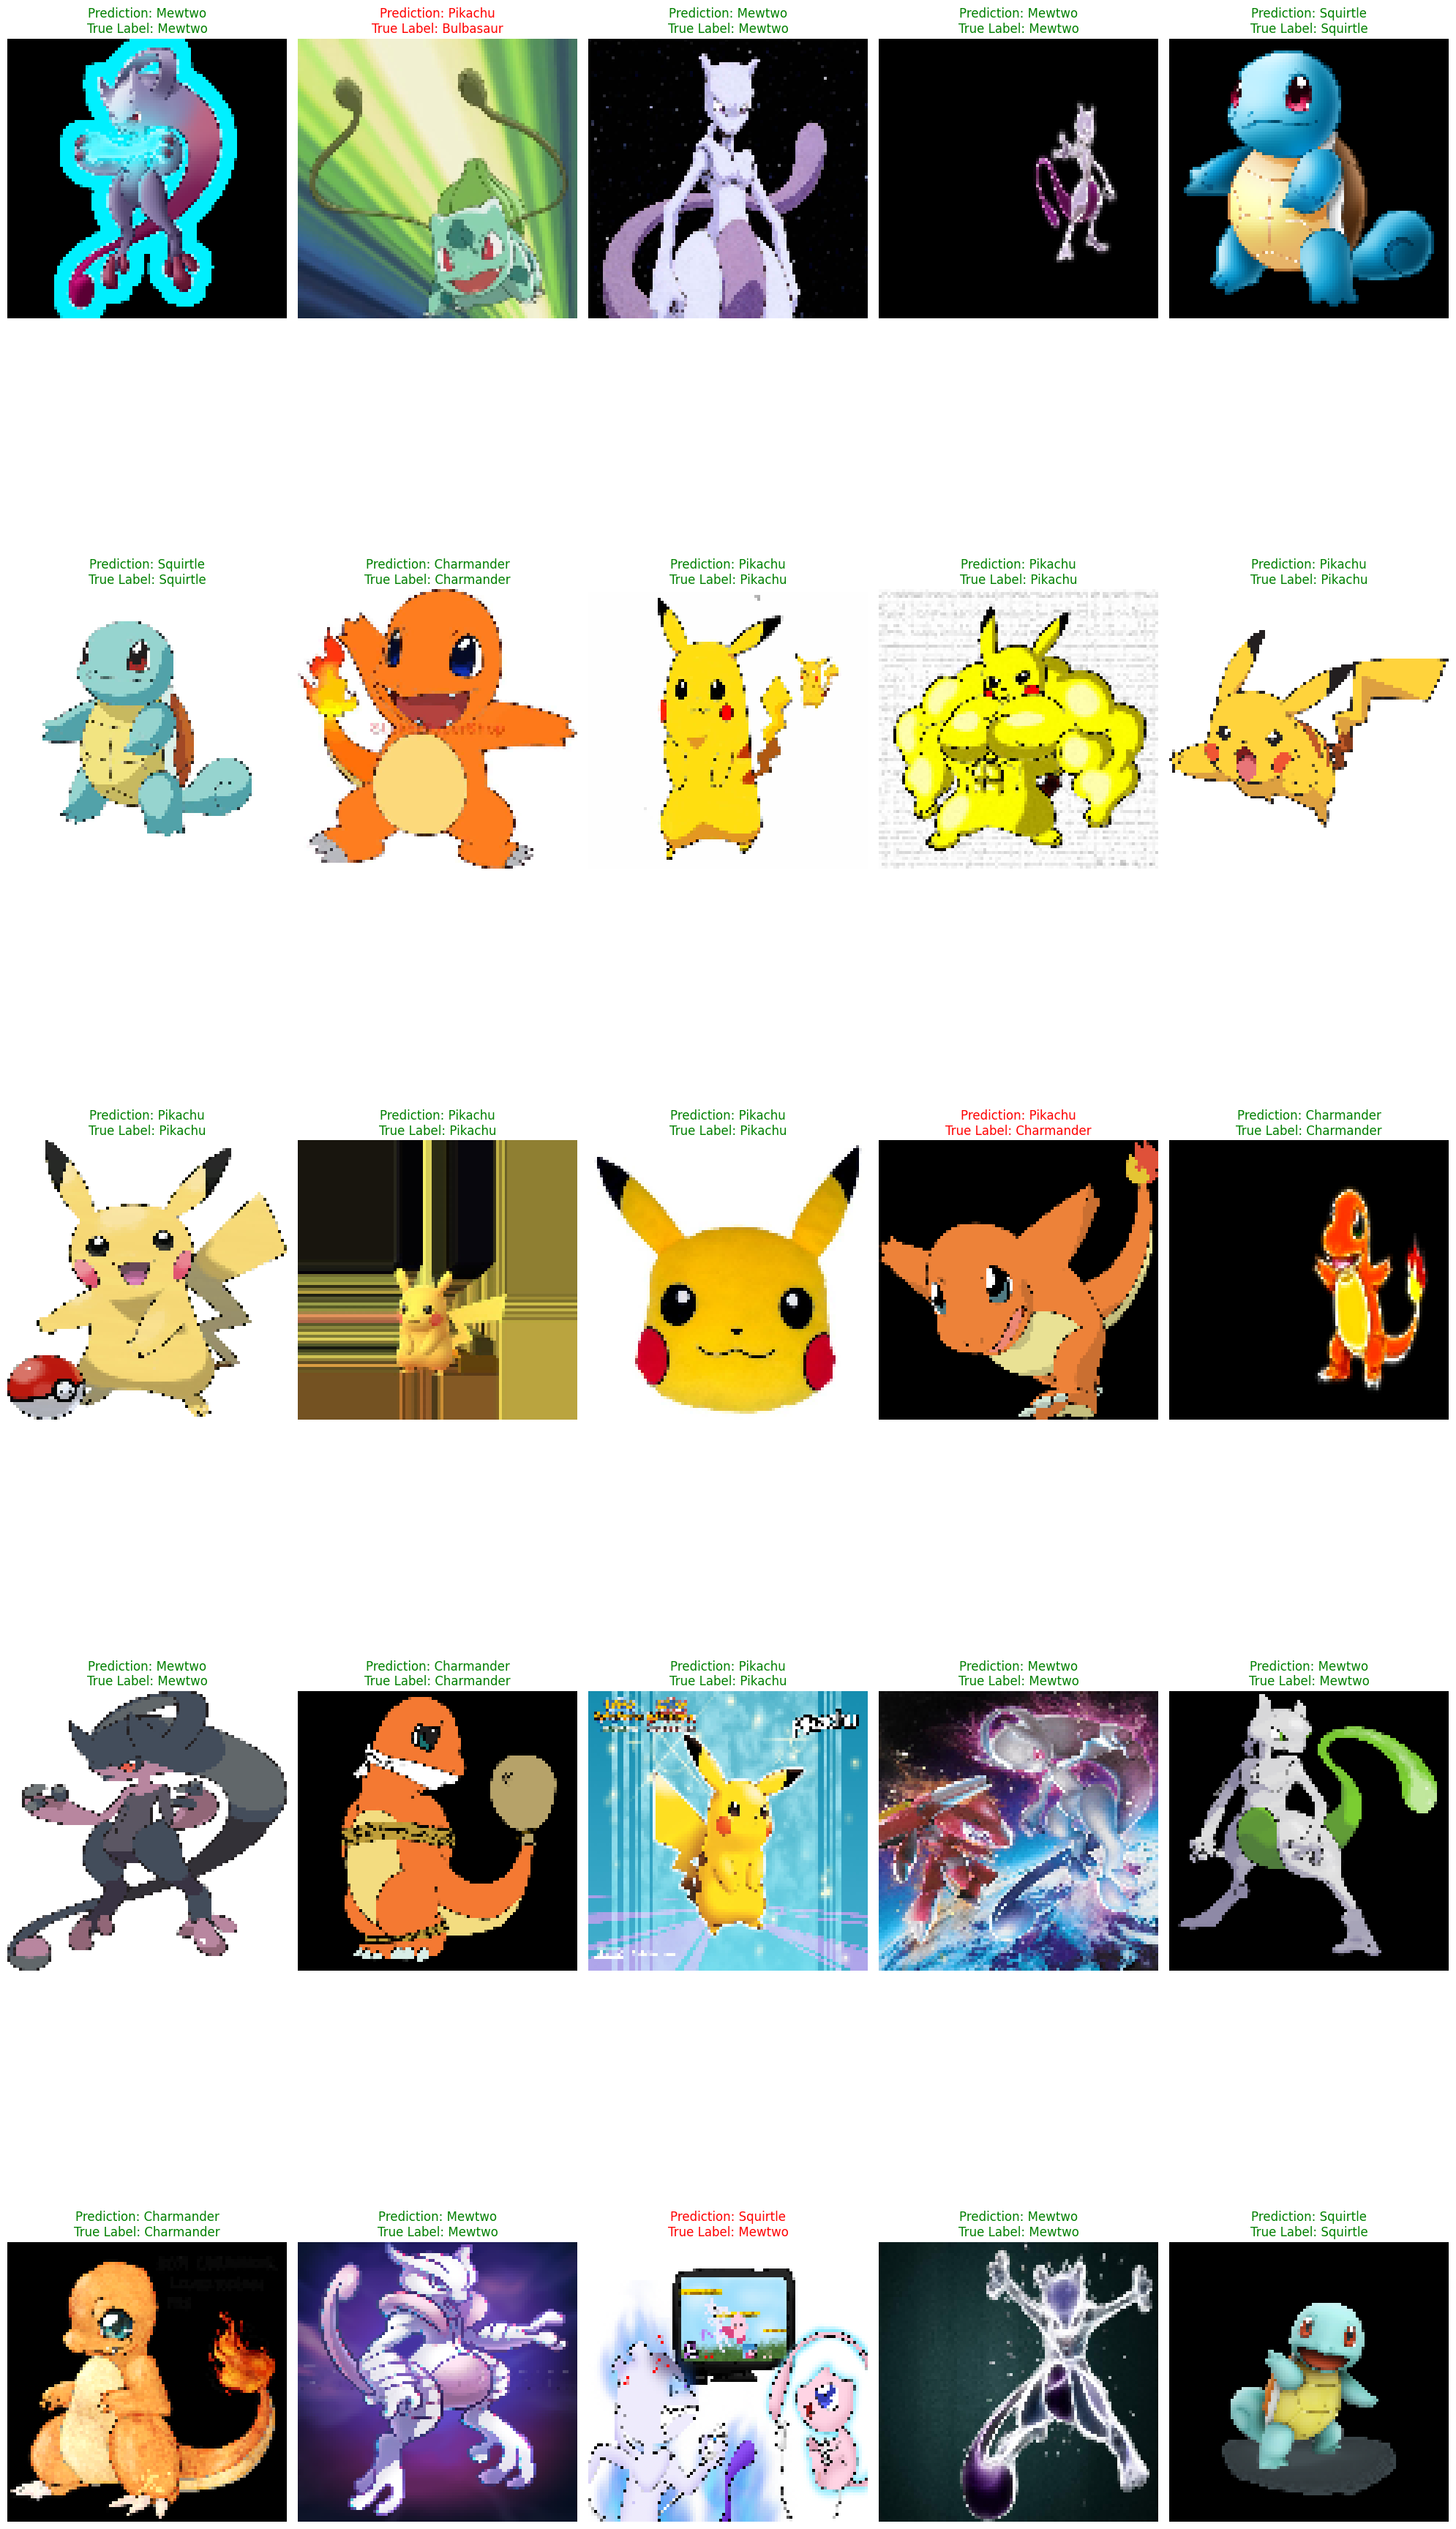

In [ ]:
num_images = 25

num_rows = 5
num_cols = 5

y_pred = model_5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

sample_indices = np.random.choice(range(len(X_test)), size=num_images, replace=False)
sample_images = X_test[sample_indices]
sample_predictions = y_pred_classes[sample_indices]
true_labels = np.argmax(y_test[sample_indices], axis=1)


plt.figure(figsize=(20, 40))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i][...,::-1])
    if sample_predictions[i] == true_labels[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Prediction: {imbalanced[sample_predictions[i]]}\nTrue Label: {imbalanced[true_labels[i]]}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#PROVIAMO 20 EPOCHE. L'ACCURACY É BUONA, 0.89. FORSE SALE.

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model_6 = Sequential()
model_6.add(conv_base)
model_6.add(Flatten())
model_6.add(Dense(512, activation='sigmoid'))
model_6.add(Dropout(0.3))
model_6.add(Dense(256, activation='sigmoid'))
model_6.add(Dropout(0.3))
model_6.add(Dense(128, activation='sigmoid'))
model_6.add(Dropout(0.3))
model_6.add(Dense(len(imbalanced), activation='softmax'))

conv_base.trainable = False

model_6.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model_6.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)

loss, accuracy = model_6.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/20
19/19 [==============================] - 174s 9s/step - loss: 1.6749 - accuracy: 0.2204 - val_loss: 1.4530 - val_accuracy: 0.3946
Epoch 2/20
19/19 [==============================] - 171s 9s/step - loss: 1.3369 - accuracy: 0.4800 - val_loss: 1.0168 - val_accuracy: 0.7313
Epoch 3/20
19/19 [==============================] - 173s 9s/step - loss: 0.8615 - accuracy: 0.7515 - val_loss: 0.6582 - val_accuracy: 0.8095
Epoch 4/20
19/19 [==============================] - 166s 9s/step - loss: 0.5267 - accuracy: 0.8630 - val_loss: 0.4771 - val_accuracy: 0.8401
Epoch 5/20
19/19 [==============================] - 165s 9s/step - loss: 0.3424 - accuracy: 0.9132 - val_loss: 0.4182 - val_accuracy: 0.8571
Epoch 6/20
19/19 [==============================] - 166s 9s/step - loss: 0.2370 - accuracy: 0.9396 - val_loss: 0.3907 - val_accuracy: 0.8810
Epoch 7/20
19/19 [==============================] - 172s 9s/step - loss: 0.1714 - accuracy: 0.9643 - val_loss: 0.3908 - val_accuracy: 0.8741
Epoch 8/20
19

10/10 [==============================] - 33s 3s/step


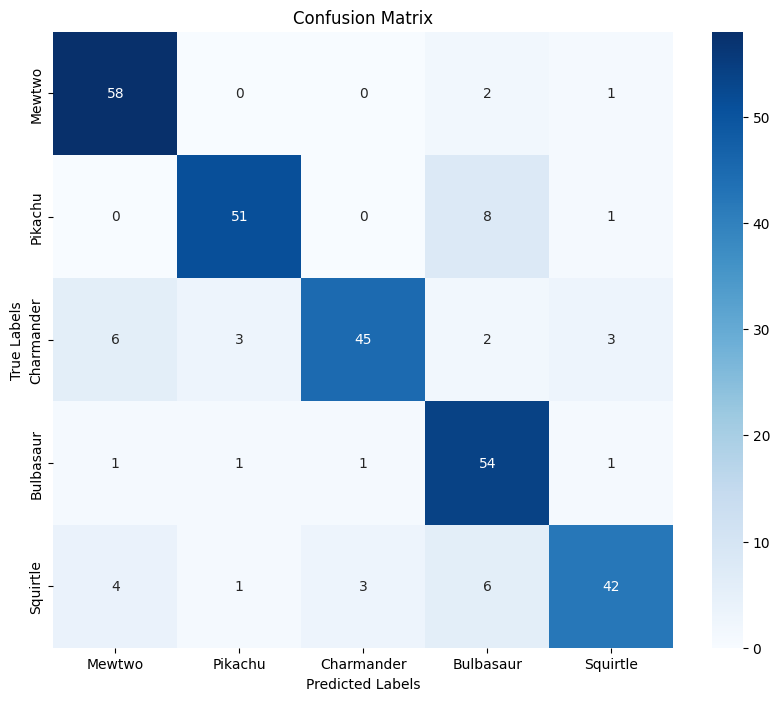

In [ ]:
# MATRICE DI CONFUSIONE MODELLO N.6

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_6.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=imbalanced, yticklabels=imbalanced)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

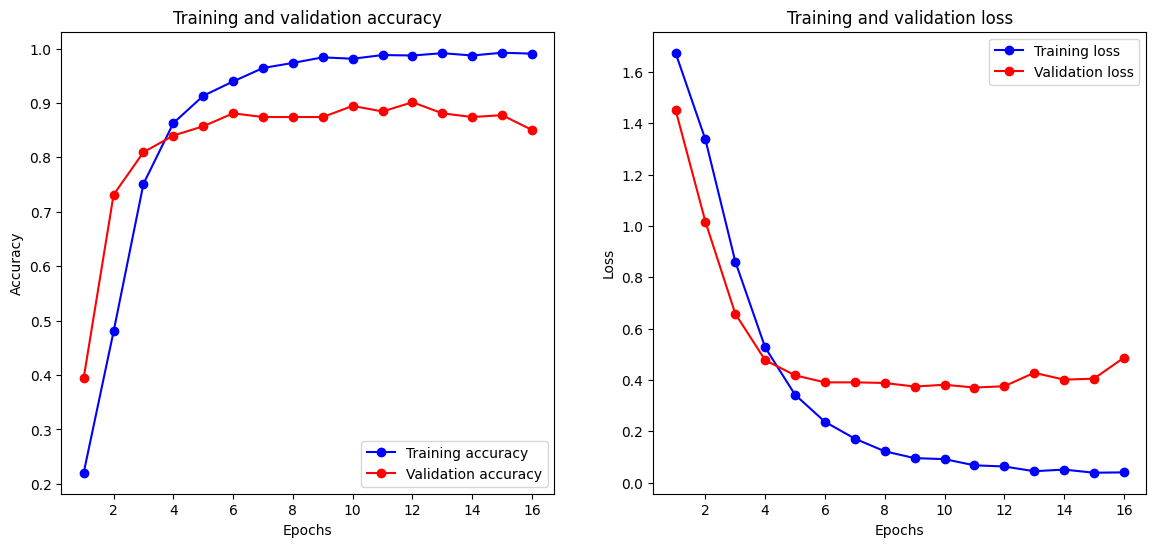

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

10/10 [==============================] - 33s 3s/step
              precision    recall  f1-score   support

      Mewtwo       0.84      0.95      0.89        61
     Pikachu       0.91      0.85      0.88        60
  Charmander       0.92      0.76      0.83        59
   Bulbasaur       0.75      0.93      0.83        58
    Squirtle       0.88      0.75      0.81        56

    accuracy                           0.85       294
   macro avg       0.86      0.85      0.85       294
weighted avg       0.86      0.85      0.85       294



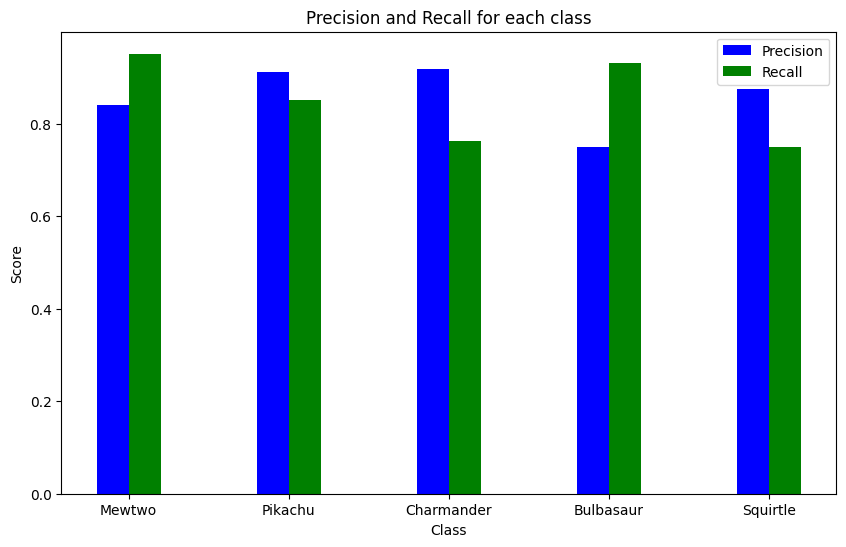

In [ ]:
# RECALL/PRECISION FIGURES MODELLO N.6

from sklearn.metrics import classification_report, precision_recall_fscore_support

y_pred = model_6.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=imbalanced)
print(report)

precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred_classes)

x = np.arange(len(imbalanced))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.1, precision, width=0.2, label='Precision', color='b')
plt.bar(x + 0.1, recall, width=0.2, label='Recall', color='g')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall for each class')
plt.xticks(x, imbalanced)
plt.legend()

plt.show()

10/10 [==============================] - 32s 3s/step


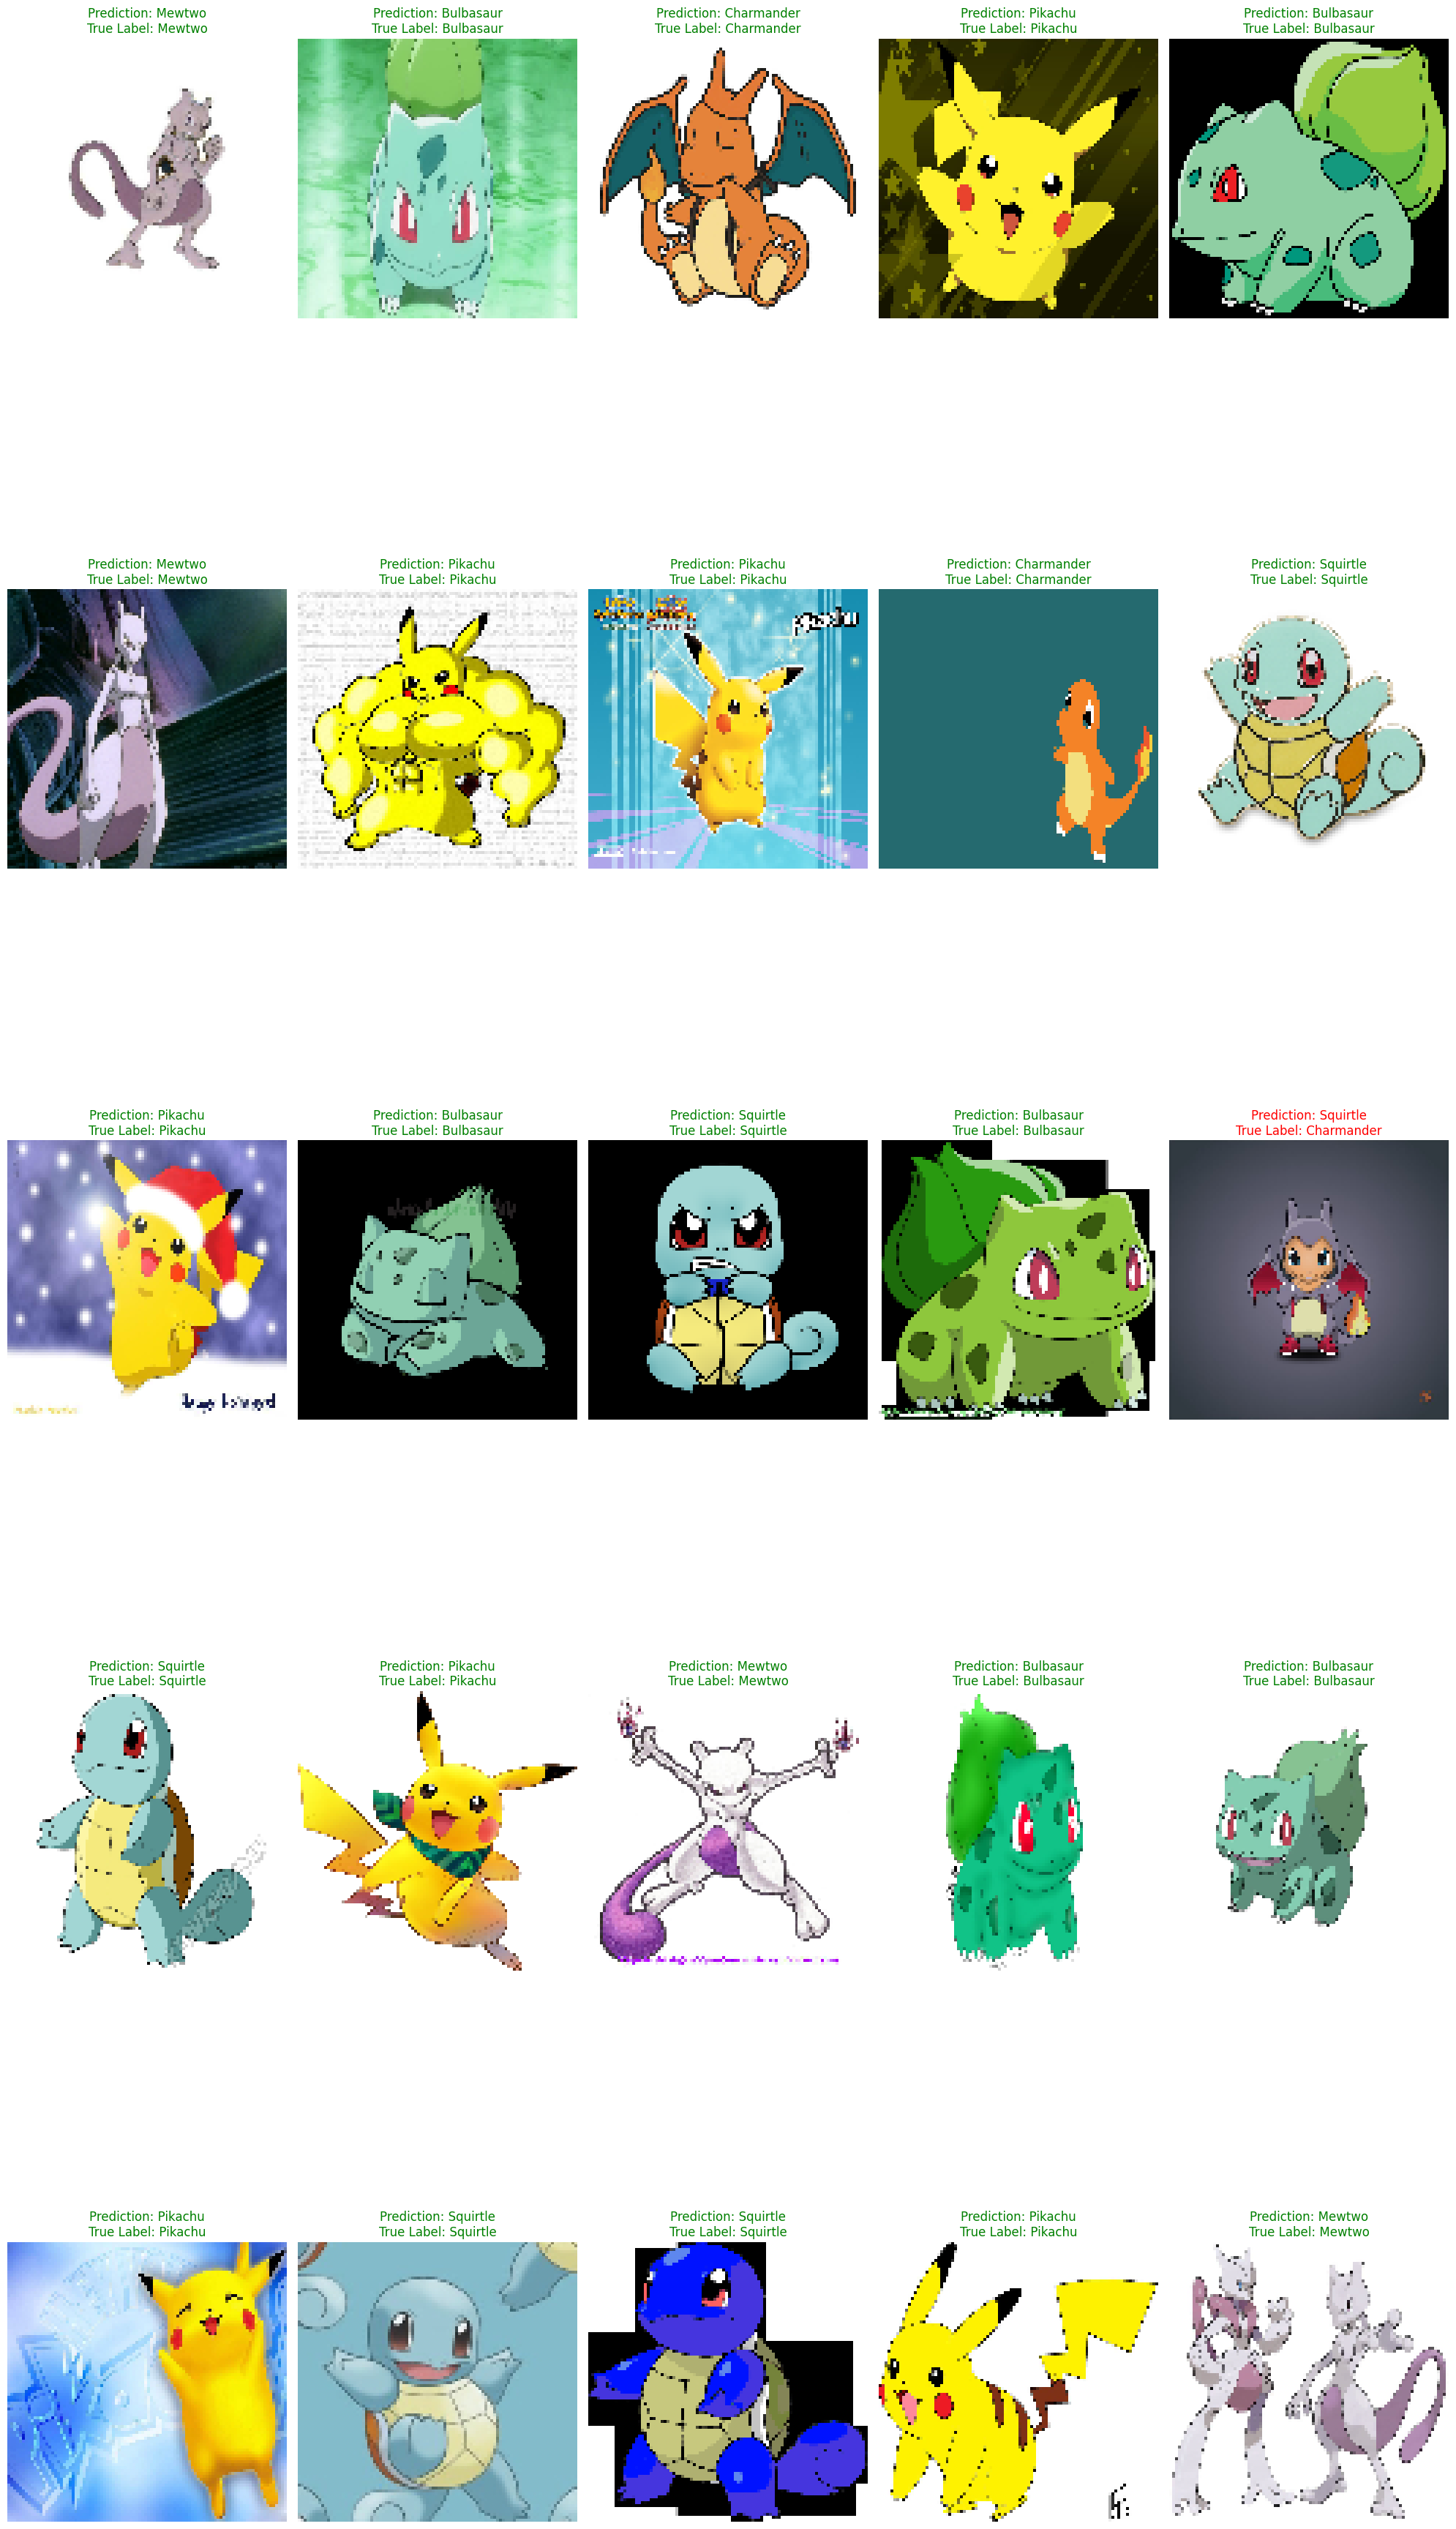

In [ ]:
num_images = 25

num_rows = 5
num_cols = 5

y_pred = model_6.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

sample_indices = np.random.choice(range(len(X_test)), size=num_images, replace=False)
sample_images = X_test[sample_indices]
sample_predictions = y_pred_classes[sample_indices]
true_labels = np.argmax(y_test[sample_indices], axis=1)

plt.figure(figsize=(20, 40))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i][...,::-1])
    if sample_predictions[i] == true_labels[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Prediction: {imbalanced[sample_predictions[i]]}\nTrue Label: {imbalanced[true_labels[i]]}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()